In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix,roc_auc_score,recall_score,precision_score

In [33]:
data = pd.read_csv('Tweets.csv')

In [34]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x == 'negative' else 0)
#we classify the neutral and positive sentiment as same
data_clean['text_clean'] = data_clean['text'].apply(lambda x : BeautifulSoup(x,'lxml').text)

In [35]:
#there is html encoding present in some of the tweets we use Beautiful sou from bs4 and lxmx parset to remove that encoding and get clean data
data_clean['text_clean']

0                      @VirginAmerica What @dhepburn said.
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
5        @VirginAmerica seriously would pay $30 a fligh...
                               ...                        
14634           @AmericanAir right on cue with the delays👌
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text_clean, Length: 13651, dtype: object

In [97]:
data_clean = data_clean.loc[:,['text_clean','sentiment']]

X = data_clean['text_clean']
y = data_clean['sentiment']

def tokenize(text):
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)
def stem(doc):
    stemmer = SnowBallStemmer()
    return (stemmer.stem(w) for w in analyzer(doc))
en_stopwords = set(stopwords.words('english'))

vectorizer = CountVectorizer(
analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range = (1,1),
    stop_words = en_stopwords
)

X = vectorizer.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=1)



1241     1
4711     1
9943     0
6455     0
11285    1
        ..
986      1
5593     1
13083    1
251      1
14325    0
Name: sentiment, Length: 10920, dtype: int64

In [102]:
kfolds = StratifiedKFold(n_splits = 5,shuffle=True,random_state=1)



svc = SVC(probability = True,kernel='linear',class_weight='balanced')

grid_svm = GridSearchCV(svc,
                        param_grid = {'C':[0.01,0.1,1]},
                        scoring='roc_auc',
                        verbose=1,
                        n_jobs = -1
                       )

grid_svm.fit(X_train,y_train)




Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=1)

In [103]:
grid_svm.best_params_


{'C': 0.1}

In [104]:
grid_svm.best_score_

0.9010733399773572

In [105]:
grid_svm.best_estimator_

SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [107]:
grid_svm.score(X_test,y_test)

0.9188979138877743

In [108]:
my_sweet_estimator = grid_svm.best_estimator_

In [113]:
pred = my_sweet_estimator.predict(X_test)


In [114]:
roc_auc_score(y_test,pred)

0.8361531936326164

In [115]:
f1_score(y_test,pred)

0.8690888119953863

In [116]:
precision_score(y_test,pred)

0.9133333333333333

In [117]:
recall_score(y_test,pred)

0.828932893289329

In [121]:
pred_proba = my_sweet_estimator.predict_proba(X_test)[:,1]

In [122]:
pred_proba

array([0.91790959, 0.07853077, 0.52392902, ..., 0.76134685, 0.16801508,
       0.86628032])

In [125]:
roc_auc_score(y_test,pred_proba)
#area under the curve

0.9188985163576597

In [127]:
predict_proba = my_sweet_estimator.predict_proba(X_test)[:,1]
false_positive_rate,true_positive_rate,_ =roc_curve(y_test,predict_proba)

Text(0, 0.5, 'True positive rate')

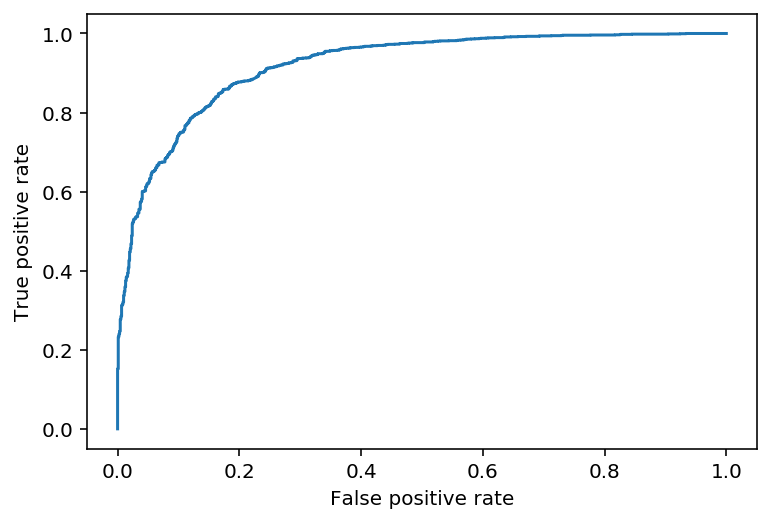

In [129]:
plt.plot(false_positive_rate,true_positive_rate)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [135]:
grid_svm.predict(["flying with @united is always a great experience"])

ValueError: could not convert string to float: 'flying with @united is always a great experience'

In [136]:
X_train

<10920x15976 sparse matrix of type '<class 'numpy.int64'>'
	with 130900 stored elements in Compressed Sparse Row format>

In [144]:
data_clean

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1
...,...,...
14634,@AmericanAir right on cue with the delays👌,1
14636,@AmericanAir leaving over 20 minutes Late Flig...,1
14637,@AmericanAir Please bring American Airlines to...,0
14638,"@AmericanAir you have my money, you change my ...",1
